# Fairness Analysis

In [171]:
import torch

import numpy as np
import pandas as pd
import tqdm

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from src.data.dataloader import CatalanJuvenileJustice
from src.models.model import FullyConnected, AutoEncoder

In [172]:
def set_seed(seed: int):
    torch.manual_seed(seed)

plt.style.use('ggplot')

In [173]:
# From course 02477 - Bayesian Machine Learning (Spring 2023)
def compute_calibration_curve(targets, probs, num_bins=10):

    bins = np.linspace(0, 1, num_bins+1)

    p_true_mean, p_true_se, p_pred = [], [], []

    for i in range(num_bins):
        bin_start, bin_end = bins[i], bins[i+1]
        bin_center = 0.5*(bin_start + bin_end)
        
        bin_idx = np.logical_and(bin_start <= probs, probs < bin_end)
        num_points_in_bin = np.sum(bin_idx)
        
        if len(targets[bin_idx]) == 0:
            continue

        p_pred.append(bin_center)
        p_est = np.mean(targets[bin_idx])
        p_true_mean.append(p_est)
        p_true_se.append(np.sqrt(p_est*(1-p_est)/num_points_in_bin))
        
    return np.array(p_true_mean), np.array(p_true_se), np.array(p_pred)

In [174]:
DATA_DIR    = "../../data" 
MODEL_DIR   = "../../models"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [175]:
def load_model(experiment: dict):
    input_parameters = experiment['model']['input_parameters']

    if experiment['model']['name'] == 'AutoEncoder':
        model = AutoEncoder(channels_in=input_parameters[0], z_dim=input_parameters[1], channels_out=input_parameters[2])
        model.encoder = experiment['model']['net'][0]
        model.classifier = experiment['model']['net'][1]
        model.load_state_dict(experiment['state_dict'])
        return model
    
    elif experiment['model']['name'] == 'FullyConnected':
        model = FullyConnected(channels_in=input_parameters[0], channels_out=input_parameters[1])
        model.net = experiment['model']['net']
        model.load_state_dict(experiment['state_dict'])
        return model
    
    else:
        raise NotImplementedError("Yet to be implemented...")

In [176]:
biasAttribute = 'V4_area_origin'
nrows, ncols, figsize = 2, 3, (20, 10)

biasAttribute = 'V1_sex'
nrows, ncols, figsize = 1, 2, (12, 4)

### Model trained with access to sensitive attributes

In [177]:
experiment_name = 'temporary-AutoEncoder-sensitive_data'

experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")
experiment.keys()

dict_keys(['experiment_name', 'seed', 'model', 'input_parameters', 'training_parameters', 'data', 'best_epoch', 'state_dict'])

In [178]:
set_seed(experiment['seed'])

dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

_, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

In [179]:
# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=84, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [180]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_representations = torch.stack(latent_representations)

100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


In [181]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [182]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.7215053763440861


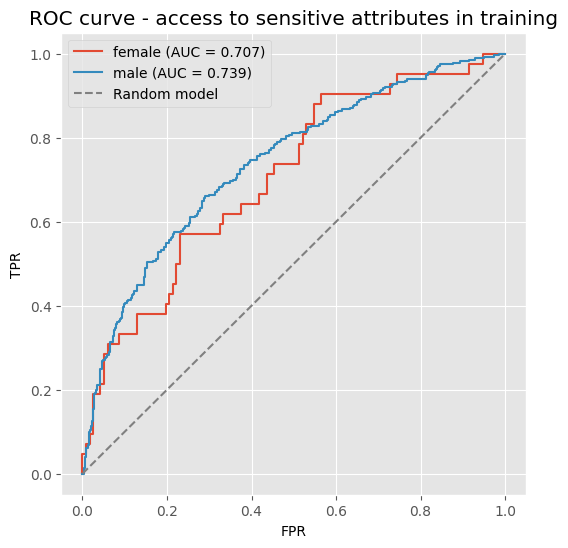

In [183]:
fairness_cols = df.iloc[:, [biasAttribute in column for column in df.columns]].columns

fig = plt.figure(figsize=(6, 6))
for i, col in enumerate(fairness_cols):
    
    # Call each category within the sensitive attribute of interest
    df_ = df.query(f"{col} == 1")

    # FPR and TPR
    fpr, tpr, threshold = roc_curve(
        df_['labels'],
        df_['pred_probs'],
    )
    performance_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=f"C{i}", label=f"{col.split('_')[-1]} (AUC = {performance_auc:.3f})")

plt.plot([0, 1], [0, 1], color='gray', ls='--', label='Random model')

plt.title("ROC curve - access to sensitive attributes in training")
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

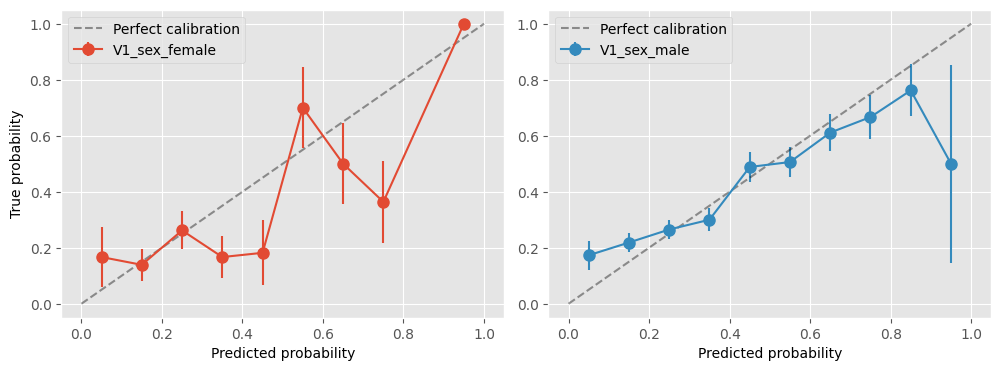

In [206]:
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
for class_idx, col in enumerate(fairness_cols):
    ax = axes.flatten()[class_idx]
    df_ = df.query(f"{col} == 1")

    p_true_mean, p_true_se, p_pred = compute_calibration_curve(df_['labels'], df_['pred_probs'])
    ax.errorbar(p_pred, p_true_mean, p_true_se, label=col, color=f"C{class_idx}", marker='o', markersize=8)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Perfect calibration')
    ax.legend(loc='upper left')

if biasAttribute == 'V4_area_origin':
    axes.flatten()[-1].axis('off')

    axes[1,0].set_xlabel('Predicted probability')
    axes[1,1].set_xlabel('Predicted probability')
    axes[0,0].set_ylabel('True probability')
    axes[1,0].set_ylabel('True probability')

elif biasAttribute == 'V1_sex':
    axes[0].set_xlabel('Predicted probability')
    axes[1].set_xlabel('Predicted probability')
    axes[0].set_ylabel('True probability')

fig.subplots_adjust(wspace=0.1)

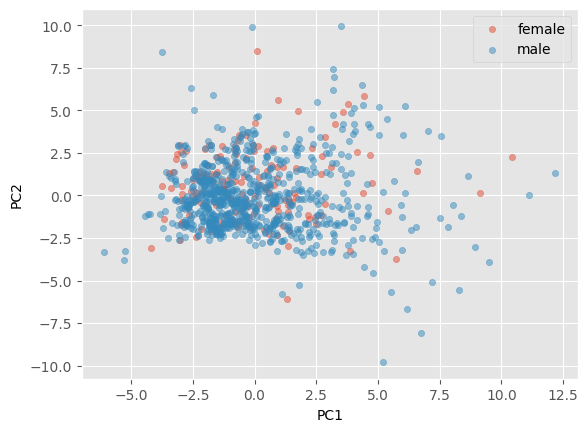

In [207]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
res = pca.fit_transform(latent_representations.cpu().numpy())

df['PC1'], df['PC2'] = res[:, 0], res[:, 1]

# Plot
df['color_by'] = df[fairness_cols].idxmax(1).apply(lambda x: x.split("_")[-1])

fig, ax = plt.subplots(1, 1)
for i, (name, sub_df) in enumerate(df.groupby('color_by')):
    sub_df.plot(x='PC1', y='PC2', kind='scatter', ax=ax, color=f"C{i}", label=name, alpha=0.5)
plt.show()

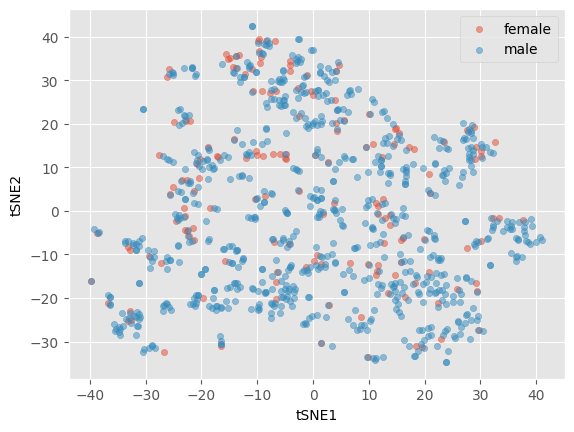

In [208]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
res = tsne.fit_transform(latent_representations.cpu().numpy())

df['tSNE1'], df['tSNE2'] = res[:, 0], res[:, 1]

# Plot
df['color_by'] = df[fairness_cols].idxmax(1).apply(lambda x: x.split("_")[-1])

fig, ax = plt.subplots(1, 1)
for i, (name, sub_df) in enumerate(df.groupby('color_by')):
    sub_df.plot(x='tSNE1', y='tSNE2', kind='scatter', ax=ax, color=f"C{i}", label=name, alpha=0.5)
plt.show()

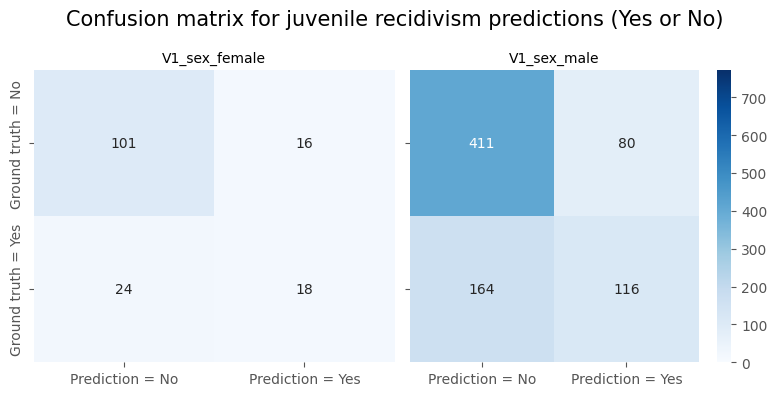

In [209]:
fig, axes = plt.subplots(1, fairness_cols.__len__(), figsize=(8, 4) if biasAttribute == 'V1_sex' else (20, 3), sharex=True, sharey=True)
for class_idx, col in enumerate(fairness_cols):
    df_ = df.query(f"{col} == 1")
    max = df['color_by'].value_counts().max()

    ax = axes.flatten()[class_idx]
    cm = confusion_matrix(df_['labels'], df_['preds'])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap='Blues', 
        ax=ax, vmin=0, vmax=max, 
        cbar=True if col == fairness_cols[-1] else False,
    )
    
    ax.set_xticks([0.5, 1.5], ['Prediction = No', 'Prediction = Yes'])
    ax.set_yticks([0.5, 1.5], ['Ground truth = No', 'Ground truth = Yes'])
    
    ax.set_title(col, fontsize=10)

fig.suptitle("Confusion matrix for juvenile recidivism predictions (Yes or No)", fontsize=15)
plt.tight_layout()
plt.show()

### Modelled trained without access to sensitive attributes

In [210]:
experiment_name = 'temporary-AutoEncoder-no_sensitive_data'

experiment = torch.load(f"{MODEL_DIR}/{experiment_name}/best.ckpt")
experiment.keys()

dict_keys(['experiment_name', 'seed', 'model', 'input_parameters', 'training_parameters', 'data', 'best_epoch', 'state_dict'])

In [211]:
set_seed(experiment['seed'])

dataset = CatalanJuvenileJustice(
    data_path=f"{DATA_DIR}/processed/{experiment['data']['filename']}"
)

_, _, test_loader = dataset.get_loaders(
    batch_size=experiment['training_parameters']['batch_size'], 
    shuffle=True, 
    num_workers=1, 
    test_size=experiment['data']['split']['test_proportion'], 
    val_size=experiment['data']['split']['val_proportion'], 
    split_type=experiment['data']['split']['split_type'],
)

In [212]:
# Load model in evaluation mode
model = load_model(experiment=experiment)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=73, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [213]:
mu      = experiment['data']['standardization']['mu']
sigma   = experiment['data']['standardization']['sigma']

sensitive_data = []
preds, pred_probs, gt_labels, equals = [], [], [], []
latent_representations = []

with torch.no_grad():
    for batch in tqdm.tqdm(iter(test_loader)):
        inputs, labels = batch['data'].to(device), batch['label'].to(device)
        sensitive_data.extend(batch['sensitive_data'])

        # Standardize input
        inputs = (inputs - mu) / sigma
        # Get predictions
        outputs = model(inputs)
        y_pred = outputs['pred']
        latent_representations.extend(outputs['z'])

        # Store predictions
        pred_probs.extend(y_pred)
        preds.extend(y_pred >= 0.5)

        # Store ground truth labels
        gt_labels.extend(labels)

preds, pred_probs, gt_labels = torch.stack(preds), torch.stack(pred_probs), torch.stack(gt_labels)
latent_representations = torch.stack(latent_representations)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(torch.stack(sensitive_data), columns=test_loader.dataset.dataset.sensitive_attributes)
df = df.rename(columns={'V4_area_origin_Latin America': 'V4_area_origin_LatinAmerica'})

df['labels'] = gt_labels.cpu()
df['pred_probs'] = pred_probs.cpu()
df['preds'] = preds.cpu().type(torch.int)

In [ ]:
print(f"Mean predictor: {1 - df['labels'].mean()}")
print(f"Trained NN: \t{(df['labels'] == df['preds']).mean()}")

Mean predictor: 0.6537634408602151
Trained NN: 	0.6946236559139785


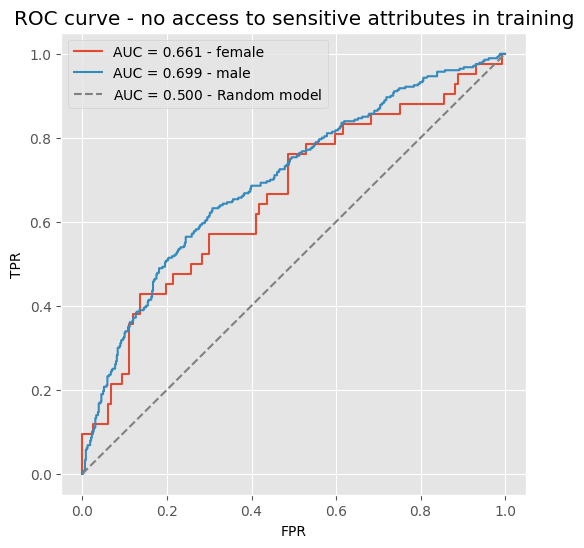

In [ ]:
fairness_cols = df.iloc[:, [biasAttribute in column for column in df.columns]].columns

fig = plt.figure(figsize=(6, 6))
for i, col in enumerate(fairness_cols):
    
    # Call each category within the sensitive attribute of interest
    df_ = df.query(f"{col} == 1")

    # FPR and TPR
    fpr, tpr, threshold = roc_curve(
        df_['labels'],
        df_['pred_probs'],
    )
    performance_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=f"C{i}", label=f"AUC = {performance_auc:.3f} - {col.split('_')[-1]}")
    
plt.plot([0, 1], [0, 1], color='gray', ls='--', label='AUC = $0.500$ - Random model')

plt.title("ROC curve - no access to sensitive attributes in training")
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

TypeError: compute_calibration_curve() got an unexpected keyword argument 'bins'

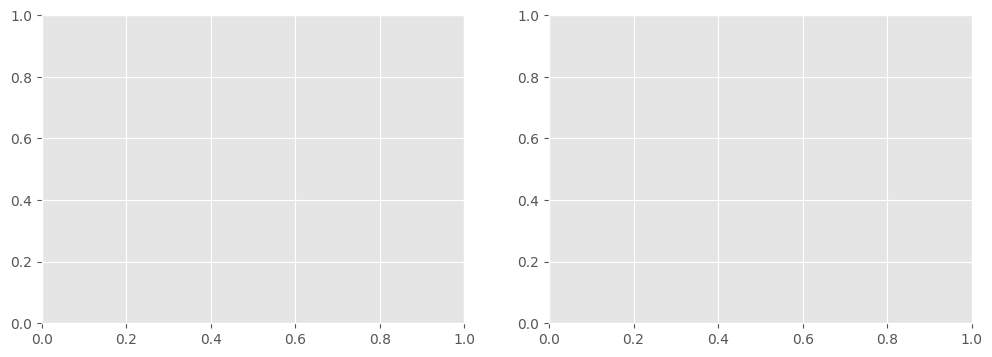

In [201]:
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
for class_idx, col in enumerate(fairness_cols):
    ax = axes.flatten()[class_idx]
    df_ = df.query(f"{col} == 1")

    p_true_mean, p_true_se, p_pred = compute_calibration_curve(df_['labels'], df_['pred_probs'], bins=100)
    ax.errorbar(p_pred, p_true_mean, p_true_se, label=col, color=f"C{class_idx}", marker='o', markersize=8)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Perfect calibration')
    ax.legend(loc='upper left')

if biasAttribute == 'V4_area_origin':
    axes.flatten()[-1].axis('off')

    axes[1,0].set_xlabel('Predicted probability')
    axes[1,1].set_xlabel('Predicted probability')
    axes[0,0].set_ylabel('True probability')
    axes[1,0].set_ylabel('True probability')
    
elif biasAttribute == 'V1_sex':
    axes[0].set_xlabel('Predicted probability')
    axes[1].set_xlabel('Predicted probability')
    axes[0].set_ylabel('True probability')


fig.subplots_adjust(wspace=0.1)


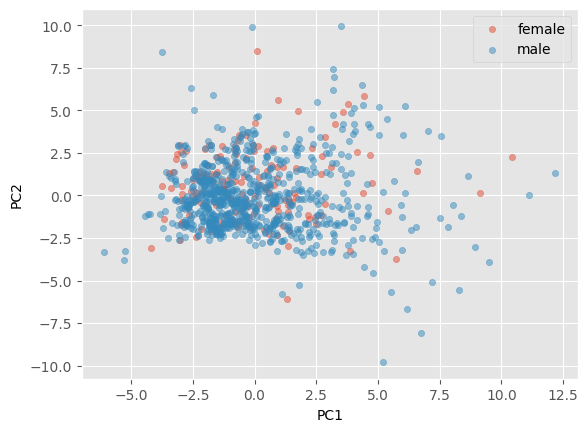

In [196]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
res = pca.fit_transform(latent_representations.cpu().numpy())

df['PC1'], df['PC2'] = res[:, 0], res[:, 1]

# Plot
df['color_by'] = df[fairness_cols].idxmax(1).apply(lambda x: x.split("_")[-1])

fig, ax = plt.subplots(1, 1)
for i, (name, sub_df) in enumerate(df.groupby('color_by')):
    sub_df.plot(x='PC1', y='PC2', kind='scatter', ax=ax, color=f"C{i}", label=name, alpha=0.5)
plt.show()

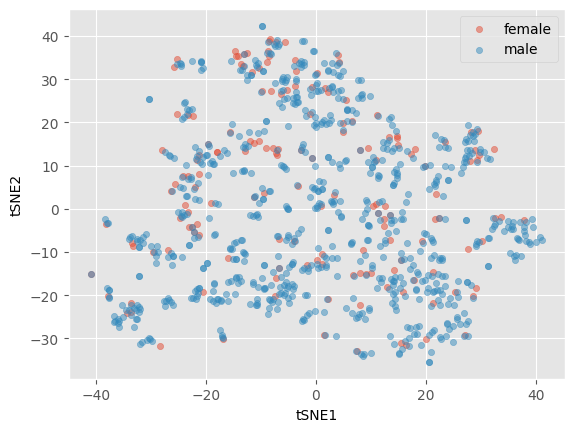

In [197]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
res = tsne.fit_transform(latent_representations.cpu().numpy())

df['tSNE1'], df['tSNE2'] = res[:, 0], res[:, 1]

# Plot
df['color_by'] = df[fairness_cols].idxmax(1).apply(lambda x: x.split("_")[-1])

fig, ax = plt.subplots(1, 1)
for i, (name, sub_df) in enumerate(df.groupby('color_by')):
    sub_df.plot(x='tSNE1', y='tSNE2', kind='scatter', ax=ax, color=f"C{i}", label=name, alpha=0.5)
plt.show()

In [198]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

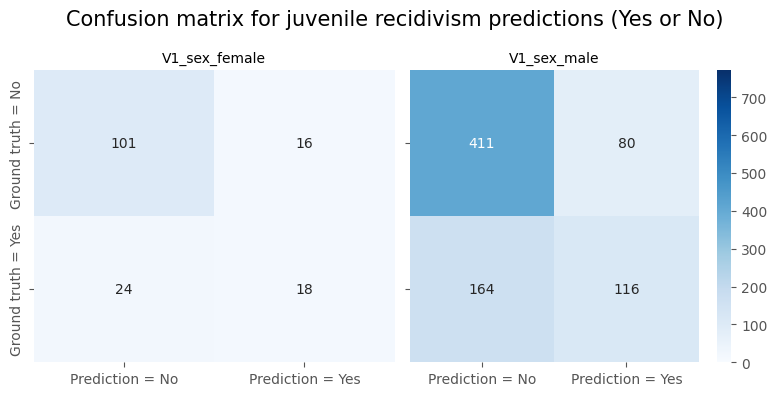

In [199]:
fig, axes = plt.subplots(1, fairness_cols.__len__(), figsize=(8, 4) if biasAttribute == 'V1_sex' else (20, 3), sharex=True, sharey=True)
for class_idx, col in enumerate(fairness_cols):
    df_ = df.query(f"{col} == 1")
    max = df['color_by'].value_counts().max()

    ax = axes.flatten()[class_idx]
    cm = confusion_matrix(df_['labels'], df_['preds'])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap='Blues', 
        ax=ax, vmin=0, vmax=max, 
        cbar=True if col == fairness_cols[-1] else False,
    )
    
    ax.set_xticks([0.5, 1.5], ['Prediction = No', 'Prediction = Yes'])
    ax.set_yticks([0.5, 1.5], ['Ground truth = No', 'Ground truth = Yes'])
    
    ax.set_title(col, fontsize=10)

fig.suptitle("Confusion matrix for juvenile recidivism predictions (Yes or No)", fontsize=15)
plt.tight_layout()
plt.show()